In [42]:
import linearmodels as lm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

In [43]:
finaldf = pd.read_csv("./data/finaldf.csv")
finaldf.TEAM = pd.Categorical(finaldf.TEAM)

teams = pd.Categorical(finaldf.TEAM).categories
seasons = finaldf.Season.unique()

finaldf = finaldf.set_index(["TEAM", "Season"])

# Descriptive

C:\Users\bhara\AppData\Local\Temp\ipykernel_13448\2722147956.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  finaldf.W.groupby("TEAM").mean().plot(kind = "bar", ylim = [0, 82])


<Axes: xlabel='TEAM'>

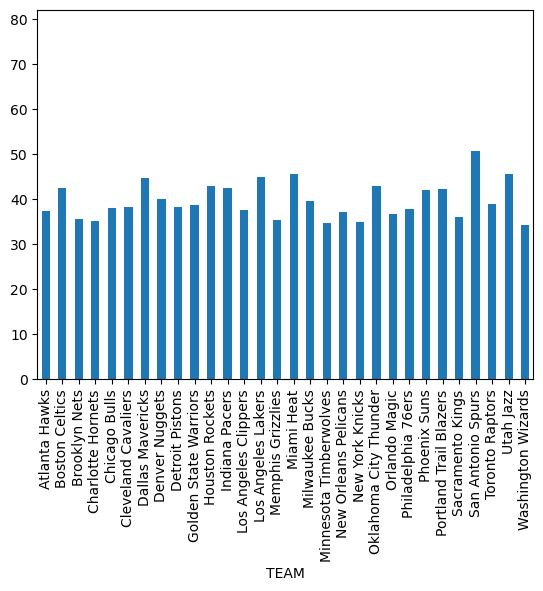

In [44]:
finaldf.W.groupby("TEAM").mean().plot(kind = "bar", ylim = [0, 82])

<Axes: xlabel='Season'>

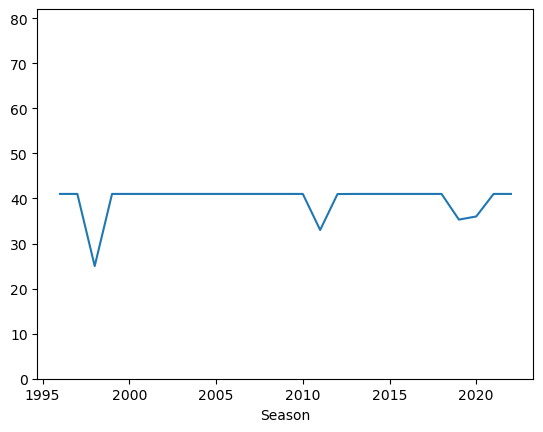

In [45]:
finaldf.W.groupby("Season").mean().plot(ylim=[0, 82])

In [46]:
finaldf = finaldf.dropna()

# Pooled OLS

In [47]:
regMod = lm.PanelOLS(finaldf.dropna()["W"], finaldf.dropna().drop(["W", "Coach"], axis = 1)).fit(cov_type = "robust")

c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:684: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:684: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:644: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

In [48]:
def sig_check(pval):
    if pval < 0.01:
        return("***")
    if pval < 0.025:
        return("**")
    if pval< 0.05:
        return("*")
    return ""

def outReg(regMod):
    regInfo = pd.DataFrame({"R^2 Between": regMod.corr_squared_between.round(2), "R^2 Within": regMod.corr_squared_within.round(2), "R^2 Overall": regMod.corr_squared_overall.round(2), "N": regMod.nobs}, index = ["Coefficients"]).T

    outdf = pd.DataFrame([regMod.params]).T.round(2)
    outdf["parameter"] = [f"{param}" + sig_check(pval) + f"\n({std_error:.2f})" for param, pval, std_error in zip(outdf.parameter.values, regMod.pvalues.values, regMod.std_errors)]
    outdf = outdf.rename({"parameter": "Coefficients"}, axis = 1)
    outdf = outdf.rename_axis("W", axis = 1)
    outdf = pd.concat([outdf, regInfo])

    return outdf

In [ ]:
# Two way fixed effect model
twofe_reg = lm.PanelOLS.from_formula(formula = 'W ~ Perc_3PA + Perc_2PA + Perc_AST + Perc_STL +'
                                    'PFminusPFD + OPP_Perc_3PA + OPP_Perc_AST + OPP_Perc_STL +'
                                    'L1_N_Awards_Won + L1_Coach_RS_W_Perc_Overall + L1_Coach_P_W_Perc +'
                                    'AVG_PLAYER_AGE + Coach_N_Seasons_Overall + Coach_Perc_Seasons_TEAM +'
                                    ' EntityEffects + TimeEffects', data = finaldf, drop_absorbed = True) 
twofe_results = twofe_reg.fit(cov_type = "clustered")

# one way random effect entity model
onere_reg = lm.RandomEffects.from_formula(formula = 'W ~ Perc_3PA + Perc_2PA + Perc_AST + Perc_STL +'
                                    'PFminusPFD + OPP_Perc_3PA + OPP_Perc_AST + OPP_Perc_STL +'
                                    'L1_N_Awards_Won + L1_Coach_RS_W_Perc_Overall + L1_Coach_P_W_Perc +'
                                    'AVG_PLAYER_AGE + Coach_N_Seasons_Overall + Coach_Perc_Seasons_TEAM', data = finaldf)
onere_results_entity = onere_reg.fit(cov_type = "clustered")

# one way random effect time model
teams = finaldf.reset_index()["TEAM"].unique()
teams = {team: team_index for team_index, team in enumerate(teams)}
finaldf2 = finaldf.reset_index()
finaldf2["TEAM"] = pd.to_numeric(finaldf2.TEAM.apply(lambda x: teams[x]))
finaldf2 = finaldf2.set_index(["Season", "TEAM"])

onere_reg = lm.RandomEffects.from_formula(formula = 'W ~ Perc_3PA + Perc_2PA + Perc_AST + Perc_STL +'
                                    'PFminusPFD + OPP_Perc_3PA + OPP_Perc_AST + OPP_Perc_STL +'
                                    'L1_N_Awards_Won + L1_Coach_RS_W_Perc_Overall + L1_Coach_P_W_Perc +'
                                    'AVG_PLAYER_AGE + Coach_N_Seasons_Overall + Coach_Perc_Seasons_TEAM', data = finaldf2)
onere_results_time = onere_reg.fit(cov_type = "clustered")


In [53]:
outdf = pd.concat([outReg(mod) for mod in [regMod, onere_results_entity, onere_results_time, twofe_results]], axis = 1)
outdf.columns = ["PooledOLS", "Entity RE", "Time RE", "Two-Way FE"]

In [114]:
def f_test(resMod, unresMod):
    rss = resMod.resid_ss
    urss = unresMod.resid_ss
    r_df = resMod.df_resid
    ur_df = unresMod.df_resid
    diff_df = r_df - ur_df

    f_stat = ((rss - urss)/diff_df)/(urss/ur_df)
    print(f"(a): F-stat: {round(f_stat, 2)},\n p-value: {round(1-f.cdf(f_stat, diff_df, ur_df), 2)},\n Distribution: F({diff_df}, {ur_df})")

onefe_reg = lm.PanelOLS.from_formula(formula = 'W ~ Perc_3PA + Perc_2PA + Perc_AST + Perc_STL +'
                                    'PFminusPFD + OPP_Perc_3PA + OPP_Perc_AST + OPP_Perc_STL +'
                                    'L1_N_Awards_Won + L1_Coach_RS_W_Perc_Overall + L1_Coach_P_W_Perc +'
                                    'AVG_PLAYER_AGE + Coach_N_Seasons_Overall + Coach_Perc_Seasons_TEAM +'
                                    'TimeEffects', data = finaldf, drop_absorbed = True) 
onefe_results = onefe_reg.fit(cov_type = "clustered")
twofe_reg = lm.PanelOLS.from_formula(formula = 'W ~ Perc_3PA + Perc_2PA + Perc_AST + Perc_STL +'
                                    'PFminusPFD + OPP_Perc_3PA + OPP_Perc_AST + OPP_Perc_STL +'
                                    'L1_N_Awards_Won + L1_Coach_RS_W_Perc_Overall + L1_Coach_P_W_Perc +'
                                    'AVG_PLAYER_AGE + Coach_N_Seasons_Overall + Coach_Perc_Seasons_TEAM +'
                                    ' EntityEffects + TimeEffects', data = finaldf, drop_absorbed = True) 
twofe_results = twofe_reg.fit(cov_type = "clustered")

f_test(onefe_results, twofe_results)

(a): F-stat: 2.14,
 p-value: 0.0,
 Distribution: F(29, 560)


c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:684: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:684: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:644: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

In [55]:
outdf.to_csv("./outputTables/summaryTables.csv")

# Coach Effects

In [8]:
import matplotlib.pyplot as plt

In [106]:
y = finaldf.W
X = finaldf.drop(["W"], axis = 1)

regMod = lm.PanelOLS(y, X).fit(cov_type = "clustered")
coachFE = pd.concat([regMod.params[12:-2], regMod.std_errors[12:-2], regMod.pvalues[12:-2]], axis = 1)
coachFE.index = coachFE.index.str.replace("Coach.", "")

c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:684: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:684: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
c:\Users\bhara\miniconda3\envs\py311\Lib\site-packages\linearmodels\panel\data.py:644: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

41


Text(0.5, 0, 'Estimated Coefficient')

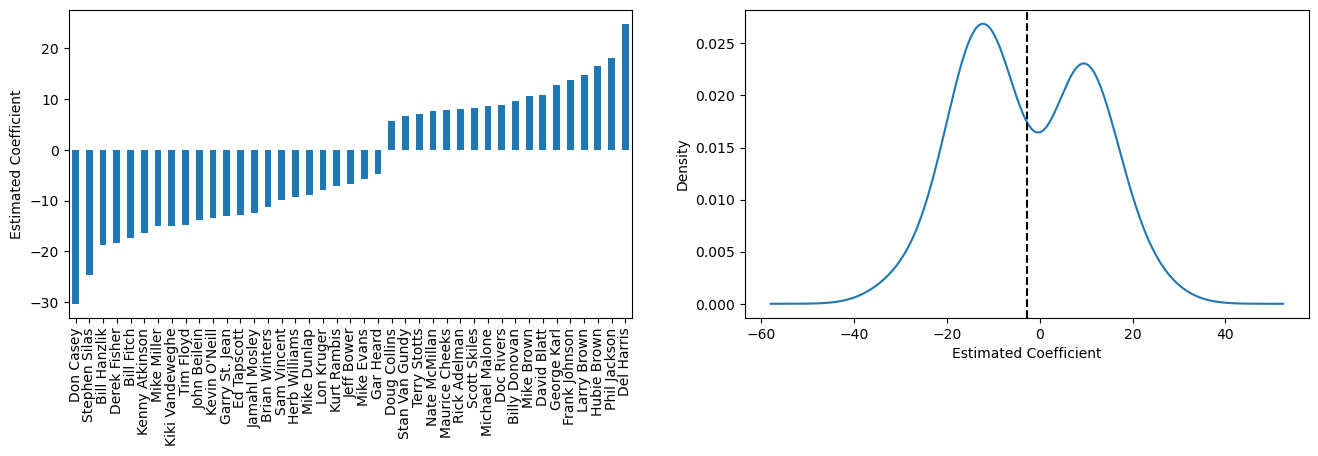

In [108]:
sigCoachFE = coachFE[coachFE.pvalue < 0.05]
print(sigCoachFE.shape[0])

fig, ax = plt.subplots(ncols = 2, figsize = (16, 4))

# fig.suptitle("Significant Coach Effects", fontsize = 14)
sigCoachFE.parameter.sort_values().plot(kind = "bar", ax = ax[0])
ax[0].set_ylabel("Estimated Coefficient")

sigCoachFE.parameter.plot(kind = "density", ax = ax[1])
ax[1].axvline(sigCoachFE.parameter.mean(), linestyle = "dashed", color = "black")
ax[1].set_xlabel("Estimated Coefficient")

In [97]:
sigCoachFE.shape[0]/coachFE.shape[0]

0.3014705882352941